In [ ]:
!git clone https://github.com/MohAlbakerKaw/FaceRecognition.git

In [79]:
import cv2, os, datetime, glob
import torch, torchvision
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from d2l import torch as d2l
from torch import nn
from torchvision import transforms

In [2]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

In [3]:
batch_size = 2

path = './FaceRecognition/Processed'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform=transform_test),
    batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transform_test),
    batch_size=batch_size, shuffle=False)

In [4]:
feature_extract = True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def FineTune(classes, device):
    '''
    classes: number of the output classes 
    device: training context (CPU or GPU)
    '''
    finetune_net = torchvision.models.vgg16(pretrained=True).to(device)
    set_parameter_requires_grad(finetune_net, feature_extract)
    num_ftrs = finetune_net.classifier[6].in_features
    finetune_net.classifier[6] = nn.Linear(num_ftrs, classes)
    
    return finetune_net

In [5]:
device = d2l.try_gpu() # Create neural net on CPU or GPU depending on your training instances
num_outputs = 3       # 3 output classes
net = FineTune(num_outputs, device)

net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
learning_rate = 0.001

#  We will only update the parameters that we have just initialized,
#  i.e. the parameters with requires_grad is True.
params_to_update = net.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = torch.optim.SGD(params_to_update, lr=learning_rate)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
def finetune_accuracy(output, label):
    # output: (batch, num_output) float32 tensor
    # label: (batch, ) int32 tensor
    return (output.argmax(axis=1) == label.float()).float().mean()

In [9]:
epochs = 3
# running_train_loss = []
# running_train_acc = []
# running_val_loss = []
# running_valid_acc = [] 

for epoch in range(epochs):
    net = net.to(device)
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    net.train()
    for i, (data, label) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        train_acc += finetune_accuracy(output, label)
        train_loss += loss
        optimizer.step()
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    net.eval()
    for i, (data, label) in enumerate(validation_loader):
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        valid_acc += finetune_accuracy(output, label)
        val_loss += criterion(output, label)
        
    # Take averages
    train_loss /= len(train_loader)
    # running_train_loss.append(train_loss)
    train_acc /= len(train_loader)
    # running_train_acc.append(train_acc)
    val_loss /= len(validation_loader)
    # running_val_loss.append(val_loss)
    valid_acc /= len(validation_loader)
    # running_valid_acc.append(valid_acc)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss.detach().cpu().numpy(), train_acc.detach().cpu().numpy(),
        val_loss.detach().cpu().numpy(), valid_acc.detach().cpu().numpy()))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: train loss 0.699, train acc 0.716, val loss 0.426, val acc 0.855
Epoch 2: train loss 0.394, train acc 0.881, val loss 0.282, val acc 0.961
Epoch 3: train loss 0.318, train acc 0.911, val loss 0.226, val acc 0.974


In [ ]:
# The validation accuracy is greater than training accuracy. This means that the model has generalized fine. 
# This usually happens when our dataset is so similar

In [10]:
# print(running_train_loss)
# print(running_train_acc)
# print(running_val_loss)
# print(running_valid_acc)
# running_epochs = [1,2,3]
# print(running_epochs)

In [11]:
torch.save(net.state_dict(), "my_model")

In [53]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

tensor([2, 0, 2, 0, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1], device='cuda:0')


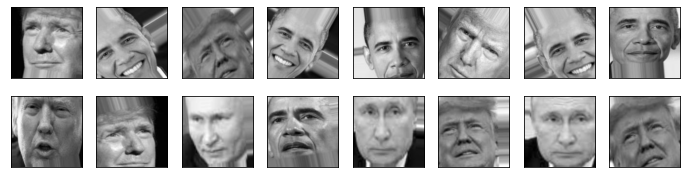

In [54]:
random_test_dataset = torchvision.datasets.ImageFolder(test_path,
                                                       transform=transform_test)
random_test_sample = torch.utils.data.DataLoader(random_test_dataset,
                                                 batch_size=2*8, shuffle=True)

net.eval()
for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.to(device)
    pred = net(data)
    print(pred.argmax(axis=1))
    break

In [18]:
def test_accuracy(net, device="gpu"):
    #trainset, testset = load_data()

    #testloader = torch.utils.data.DataLoader(
        #testset, batch_size=2, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [20]:
test_acc = test_accuracy(net, device)
print("test set accuracy: {}".format(test_acc))

test set accuracy: 0.925


In [63]:
cascPath = "./FaceRecognition/Configuration_Files/haarcascade_frontalface_default.xml"
face_class = cv2.CascadeClassifier(cascPath)

#convert_tensor = transforms.ToTensor()

# Using harrcascade frontal face to extract the face.
def face_extractor(photo):
  # the photo should be in gray scale
  detected = face_class.detectMultiScale(photo)
  if detected == ():
    return None
  else:
    (x, y, w, h) = detected[0]
    cphoto = photo[y:y+h, x:x+w]
    output = cv2.resize(cphoto, (150,150))
  return output

In [66]:
loader = transforms.Compose([transforms.Resize(224),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0,0,0), std=(1,1,1))
                            ])

In [67]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

In [51]:
image = image_loader('./test.jpg')

In [128]:
decoder = {0:'Obama', 1:'Putin', 2:'Trump'}

import warnings
warnings.filterwarnings('ignore')

def main(image):
    image = cv2.imread('./test.jpg', 0)
    face = face_extractor(image)
    im = Image.fromarray(np.uint8(cm.gist_earth(face)*255)).convert('RGB')
    image = loader(im).float()
    image = image.unsqueeze(0) #this is for VGG, may not be needed for ResNet
    image = image.cuda() #assumes that you're using GPU
    result = net(image)
    argmax = torch.argmax(result, dim=1)
    output = decoder.get(argmax.item())
    return output

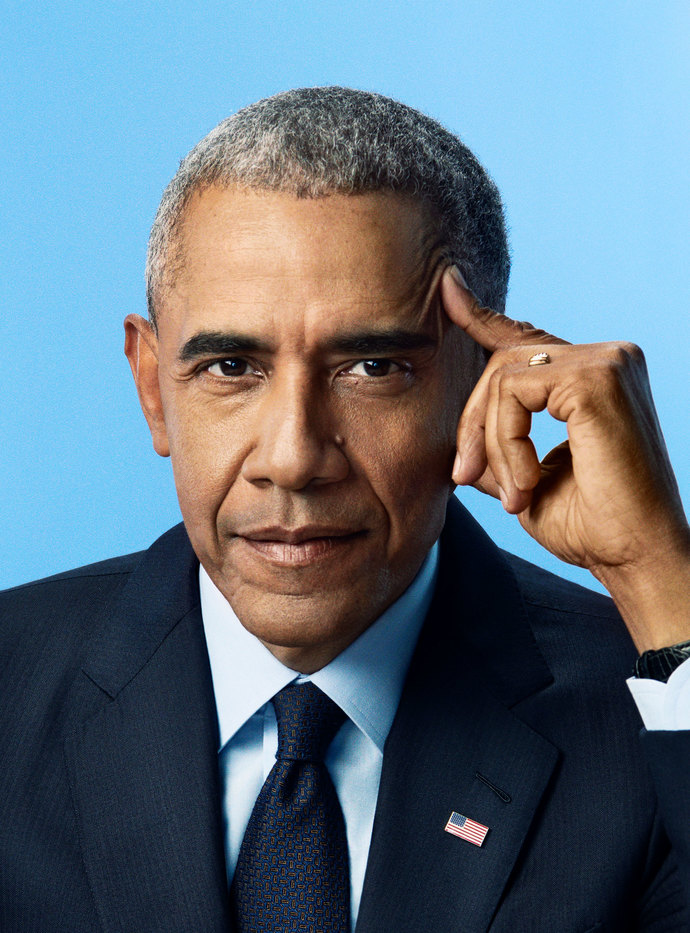

In [131]:
im = Image.open('./test.jpg')
im.show()

In [129]:
main('./test.jpg')

'Obama'